In [1]:
import numpy as np
import mnist
from skimage import transform
import skopt
import os

import matplotlib.pyplot as plt
%matplotlib inline

(6000, 28, 28)
(1000, 28, 28)


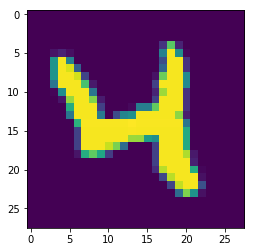

In [2]:
X_train, y = mnist.read(dataset='training', path=os.getcwd()+'/data/')
X_train = X_train.reshape(-1, 28, 28)
X_test, y_test = mnist.read(dataset='testing', path=os.getcwd()+'/data/')
X_test = X_test.reshape(-1, 28, 28)

X_train = X_train.astype('float')/255.0
X_test = X_test.astype('float')/255.0


X_train = X_train[range(0,len(X_train),10),:,:]
X_test = X_test[range(0,len(X_test),10),:,:]
y_test = y_test[range(0,len(X_test),10)]

print(X_train.shape)
print(X_test.shape)
plt.imshow(X_train[2])

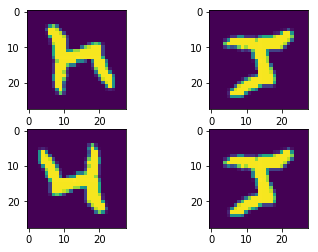

In [3]:
image_datas = [transform.rotate(X_train[2],angle) for angle in [-180,90,0,90]]
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(image_datas[0])
axarr[0,1].imshow(image_datas[1])
axarr[1,0].imshow(image_datas[2])
axarr[1,1].imshow(image_datas[3])

In [4]:
def generate_data(angle):
    """Rotate all images
    **Parameters**
        :alpha: float; Rotation angle in degrees in counter-clockwise direction.
    """
    X_train_r = np.array([transform.rotate(img,angle) for img in X_train])
    X_test_r = np.array([transform.rotate(img,angle) for img in X_test])    
    return X_train_r, X_test_r

In [5]:
%%time
X_train_90, X_test_90 = generate_data(90.0)

CPU times: user 1.85 s, sys: 40 ms, total: 1.89 s
Wall time: 1.85 s


In [6]:
from sklearn.metrics import log_loss,accuracy_score
def lower_bound_value(model,angle):
    """Find a value of classifier in point
    **Parameters**
        :model: model with functions fit/predict_proba
        :alpha: float; Rotation angle in degrees in counter-clockwise direction.
    """
    X_train_r,X_test_r = generate_data(angle)
    y_train = np.zeros(X_train.shape[0])
    y_train_r = np.ones(X_train_r.shape[0])
    y_test = np.zeros(X_test.shape[0])
    y_test_r = np.ones(X_test_r.shape[0])
    
    y = np.concatenate([y_train,y_train_r], axis = 0)
    X = np.concatenate([X_train,X_train_r], axis = 0)
    
    model.fit(X.reshape(X.shape[0],-1),y)
    
    y_val = np.concatenate([y_test,y_test_r], axis = 0).astype('float')
    X_val = np.concatenate([X_test,X_test_r], axis = 0)
    y_pred = model.predict_proba(X_val.reshape(X_val.shape[0],-1))
    return np.log(2) - log_loss(y_val,y_pred)


def find_minimize_function(model):
    """Find a minimize function with current model (Wrapper)
    **Parameters**
        :model: model with functions fit/predict
    """
    def minimize_function(angle):
        return lower_bound_value(model,angle)
    return minimize_function

In [8]:
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from skopt import Optimizer


# Optimization. Two steps

def get_previous_value(angle, last_optimizer):
    """Find a value on previous step if it has sense.
    Return -1, if we must check this point, or value in this point if previous iteration is enough.
    **Parameters**
        angle - float
    """
    if last_optimizer == None:
        return -1;
    else:
        mu,sigma = last_optimizer.models[-1].predict(optimizer.space.transform([angle]), return_std=True)
        if mu[0]-sigma[0] > np.log(2)/4.0:
            return mu[0];
        else:
            return -1;
        
def visualise(optimizer):    
    points = np.linspace(-180, 180, 360).reshape(-1, 1)
    mu, sigma = optimizer.models[-1].predict(optimizer.space.transform(list(points)), return_std=True)
    plt.plot(points, mu, "r", label="Upper bound by classifier")
    plt.plot(points, mu+sigma, "g--")
    plt.plot(points, mu-sigma, "g--")
    plt.scatter(optimizer.Xi,optimizer.yi,c='b')
        
    plt.legend()
    plt.grid()
    plt.show()

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

[-5.662354403185049] 0.011244572720799595
[120.75549956865683] 0.4481791255722736
[-99.94753152761808] 0.4566107912686357
[-160.79446895646737] 0.4156868462832043
[120.79681754597453] 0.44815372326670516
[-127.1045111854242] 0.4445352035090485
[160.05093276283083] 0.41505755453568227
[-111.2455639374421] 0.45343502805003827
[-141.0853598936254] 0.43463178206569436
[-2.9023804259394126] 0.003044167199331871
[26.159651844467163] 0.1745483205519195
[2.298245203707836] 0.002914653286272495
[0.41211037782403537] 0.00010312587537597562
[0.3458803387786986] 7.28702317349672e-05
[0.31175756884644557] 5.929645226088187e-05



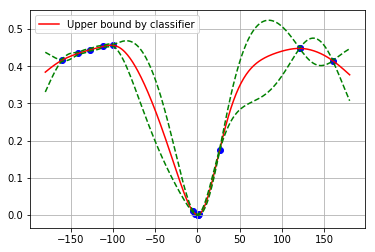

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

!
[-102.79826321257498] 0.45669174312908095
!
[151.8361205289355] 0.42704743321417343
!
[129.82989850700403] 0.44613365427672336
!
[-90.08901861752096] 0.4469943274883739
[-34.6898168547377] 0.3862765850539609
!
[-128.211922971666] 0.44376118572923745
!
[72.22632877752972] 0.41250905061604937
!
[-147.56189939871902] 0.4294065104542896
!
[-77.65431230516025] 0.4146890422742334
[-15.2185700489716] 0.12538025927631447
[-8.934946383576573] 0.03253154372842293
[14.036960958404649] 0.11784721930502584
[-3.218153734866121] -0.0013304246042976642
[0.13581854321685682] 6.761470953686732e-06
[-2.1175436309665656] -0.0014253747101063974



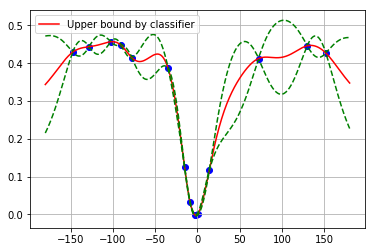

In [10]:
models = [LogisticRegression(C=1e-3),LogisticRegression()]
last_optimizer = None

n_points = 15 # number of points
n_initial_points = 10
angle_bound = (-180.0,180.0)

for model in models:
    optimizer = Optimizer([angle_bound],n_initial_points=n_initial_points)
    minimize_func = find_minimize_function(model)
    for i in tqdm_notebook(range(n_points)):
        angle = optimizer.ask()
        prev_val = get_previous_value(angle, last_optimizer)
        if prev_val == -1:
            f_val = minimize_func(angle[0])
        else:
            print('!',)
            f_val = prev_val
        optimizer.tell(angle, f_val)
        print(angle,f_val)
    
    visualise(optimizer)
    last_optimizer = optimizer